In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import holidays as hd

from time import time
import datetime
import random

from statsmodels.tsa.seasonal import STL

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import tensorflow as tf
from keras.layers import Input, Dense, LeakyReLU, LSTM, Dropout
from keras.layers import Conv1D, MaxPooling1D, Flatten, Reshape
from keras.optimizers import Adam, SGD, RMSprop, Adagrad, Nadam
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential, load_model, Model

import keras_tuner
from keras_tuner.tuners import BayesianOptimization

from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

## Loading Data

In [ ]:
# Set main working directory and secondary folder paths
directory = os.getcwd() # get working directory
data_path = directory + "/data/"
models_path = directory + "/models/"

In [ ]:
# Read the relevant weather data from the weather.csv file
weather = pd.read_csv(data_path+'weather'+'.csv')
weather.columns = weather.iloc[1]
weather = weather.iloc[2:]
weather['date'] = pd.to_datetime(weather['time']) # convert timestamps to dates
weather = weather.loc[weather['date'] >= '2015-01-01 00:00:00'] # keep data from 2015 onwards
weather.index = weather['date'] # set the date as the index
weather = weather[['temperature', 'irradiance_surface', 'precipitation', 'cloud_cover']]

<ipython-input-70-3c3c69d1651e>:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  weather = pd.read_csv(data_path+'weather'+'.csv')


In [ ]:
# Read the relevant consumption data from the consumption.csv file
consumption = pd.read_csv(data_path+'consumption'+'.csv')
consumption['date'] = pd.to_datetime(consumption['utc_timestamp'], format='%Y-%m-%dT%H:%M:%SZ') # convert timestamps to dates
consumption.index = consumption['date'] # set the date as the index
consumption = pd.DataFrame(consumption['ES_load_actual_entsoe_transparency'][1:])
consumption.columns = ['load']

In [ ]:
# combine consumption and weather data into a single dataframe
data = pd.concat([consumption, weather], axis=1)
data

,load,temperature,irradiance_surface,precipitation,cloud_cover
date,,,,,
2015-01-01 00:00:00,NaN,3.438,0.0,0.0002,0.1066
2015-01-01 01:00:00,22734.0,3.217,0.0,0.0003,0.1254
2015-01-01 02:00:00,21286.0,3.103,0.0,0.0004,0.121
2015-01-01 03:00:00,20264.0,3.051,0.0,0.0004,0.095
2015-01-01 04:00:00,19905.0,2.982,0.0,0.0003,0.083
...,...,...,...,...,...
2019-12-31 19:00:00,29362.0,8.295,0.0,0.0001,0.1557
2019-12-31 20:00:00,27608.0,7.805,0.0,0.0001,0.1382
2019-12-31 21:00:00,25241.0,7.342,0.0,0.0003,0.1363


In [ ]:
# Look for NaN values
print(f'A total of {data.isnull().values.sum()} NaN values:\n')
data.index[data.isnull().any(axis=1)]

A total of 19 NaN values:



DatetimeIndex(['2015-01-01 00:00:00', '2015-01-02 06:00:00',
               '2015-01-02 07:00:00', '2015-01-02 08:00:00',
               '2015-01-02 11:00:00', '2015-01-02 12:00:00',
               '2015-01-02 13:00:00', '2015-01-02 14:00:00',
               '2015-01-02 15:00:00', '2015-01-02 16:00:00',
               '2015-01-02 17:00:00', '2015-01-02 18:00:00',
               '2015-05-01 10:00:00', '2015-05-01 11:00:00',
               '2015-05-01 12:00:00', '2015-05-01 13:00:00',
               '2015-05-01 14:00:00', '2015-05-01 15:00:00',
               '2019-12-31 23:00:00'],
              dtype='datetime64[ns]', name='date', freq=None)

In [ ]:
def fill_nan(df):
  """
  Replaces NaN values by using the forward and backward fill method.

  Args
  ---------
  pd.DataFrame df: the original dataframe with NaN values

  Returns
  -------
  pd.DataFrame df: the cleaned dataframe
  """
  df.fillna(method='ffill', inplace=True)
  df.fillna(method='bfill', inplace=True)
  return df

In [ ]:
# Fix NaN values
data = fill_nan(data)

In [ ]:
legends = {
    0: 'Load (MW)',
    1: 'Temperature (C)',
    2: 'Irradiance (W/m^2)',
    3: 'Precipitation (mm/hour)',
    4: 'Cloud Cover [0,1]'
}

colors = sns.color_palette()
sns.set_theme(style='darkgrid')

## Preprocessing

### Z-score outlier detection

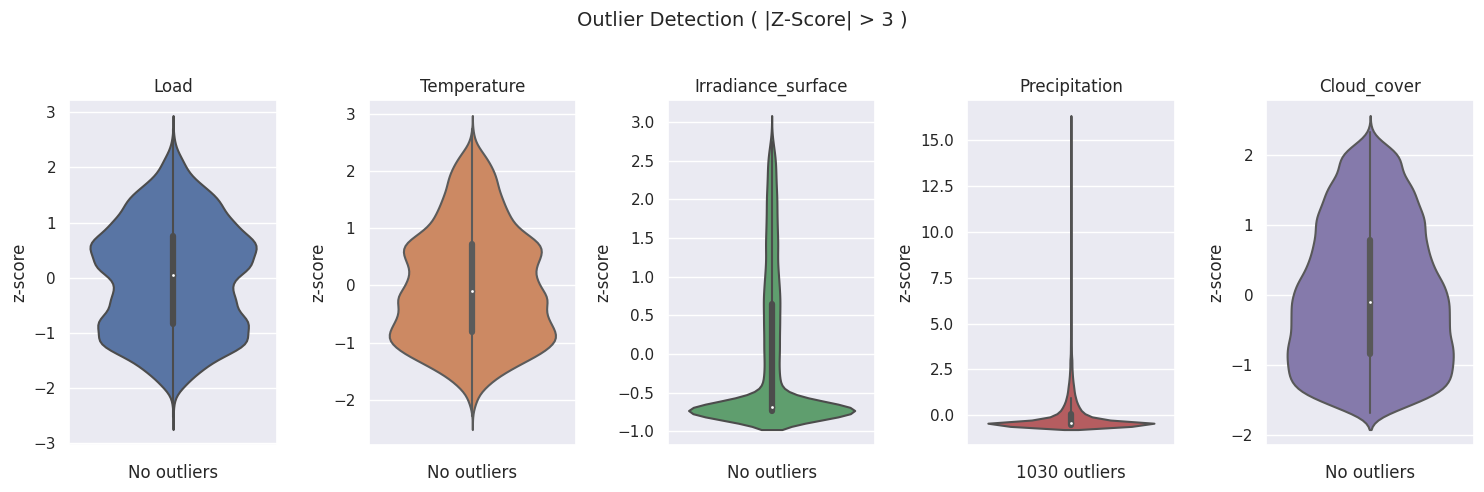

In [ ]:
def find_outliers(df):
  """
  Finds and plots outliers on each feature of a dataframe.

  Args
  ---------
  pd.DataFrame df: the original dataframe
  """
  # Create as many sublplots as the features
  fig, axes = plt.subplots(nrows=1, ncols=len(df.columns), figsize=(15, 5))

  # for every feature of the data set
  for i, feature in enumerate(df.columns):
    d = df[feature]

    # calculate the Z-score of each data point
    z_scores = (d - d.mean()) / d.std()

    # identify any points with a Z-score > 3
    outliers = d[abs(z_scores) > 3]

    # create plot showing if there are any outliers
    sns.violinplot(data=z_scores, ax=axes[i], color=colors[i])

    title = 'No outliers'
    if len(outliers) > 0:
      title = f'{len(outliers)} outliers'

    axes[i].set_title(feature.capitalize())
    axes[i].set_ylabel('z-score')
    axes[i].set_xlabel(title)
    axes[i].set_xticklabels('')

  fig.suptitle("Outlier Detection ( |Z-Score| > 3 )\n", fontsize=14)
  plt.tight_layout()
  plt.show()
  return

colors = sns.color_palette()
sns.set_theme(style='darkgrid')
find_outliers(data)

### Augmentation

In [ ]:
# create a one-hot encoded day category dataframe
weekday_map = {'Monday':    'mon',
               'Tuesday':   'wkd',
               'Wednesday': 'wkd',
               'Thursday':  'wkd',
               'Friday':    'fri',
               'Saturday':  'wkn',
               'Sunday':    'wkn'}

day_cat = pd.get_dummies(data.index.day_name().map(weekday_map))[['mon', 'wkd', 'fri', 'wkn']]
day_cat

,mon,wkd,fri,wkn
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0
...,...,...,...,...
43819,0,1,0,0
43820,0,1,0,0
43821,0,1,0,0
43822,0,1,0,0


In [ ]:
# # retrieve holiday list dictionary from the top-4 most populated provinces
years = range(2015, 2020)
provinces = ['MD', 'AN', 'CT', 'VC'] # [Madrid, Andalusia, Catalonia, Valencia]
holiday_list = hd.ES(years=years, prov=provinces[0])
for province in provinces:
  holiday_list.update(hd.ES(years=years, prov=province))

print(f'Number of total holidays: {len(holiday_list)}')

# create binary dataframe with value=1 if the day is a holiday
holidays = pd.DataFrame(data.index)
holidays['hld'] = 0
holidays.loc[holidays['date'].apply(lambda d: d in holiday_list), 'hld'] = 1
holidays = pd.DataFrame(holidays['hld'])
holidays.index = data.index
holidays

Number of total holidays: 92


,hld
date,
2015-01-01 00:00:00,1
2015-01-01 01:00:00,1
2015-01-01 02:00:00,1
2015-01-01 03:00:00,1
2015-01-01 04:00:00,1
...,...
2019-12-31 19:00:00,0
2019-12-31 20:00:00,0
2019-12-31 21:00:00,0


### Transformation

In [ ]:
# convert load from MW to GW
data['load'] /= 1000.0

In [ ]:
# Use Standard Scaliner to normalize all the unique data features
scalers = {}

for feature in data.columns:
  scaler = StandardScaler()
  data[feature] = scaler.fit_transform(np.array(data[feature]).reshape(-1, 1))
  scalers.update({feature: scaler})

In [ ]:
data.describe()

,load,temperature,irradiance_surface,precipitation,cloud_cover
count,4.382400e+04,4.382400e+04,4.382400e+04,4.382400e+04,4.382400e+04
mean,4.864066e-16,3.320536e-16,-2.594168e-17,-6.744838e-17,-1.219259e-16
std,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00
min,-2.518242e+00,-2.283490e+00,-7.421028e-01,-5.498245e-01,-1.687913e+00
25%,-8.471838e-01,-8.177143e-01,-7.421028e-01,-5.273822e-01,-8.391267e-01
50%,4.471504e-02,-1.044044e-01,-6.896978e-01,-4.056754e-01,-1.042268e-01
75%,7.615632e-01,7.168984e-01,6.509381e-01,6.043541e-02,7.755073e-01
max,2.704697e+00,2.733647e+00,2.845695e+00,1.611623e+01,2.320819e+00


## Feature Extraction

```
[ X data ]
--------------------------------
H1. Consumption   Nd X 24h
H2. Temperature   Nd X 24h
H3. Irradiance    Nd X 24h
H4. Precipitation Nd X 24h
H5. Cloud Cover   Nd X 24h

F1. Temperature Forecast   24h
F2. Irradiance Forecast    24h
F3. Precipitation Forecast 24h
F4. Cloud Cover Forecast   24h

C1. Day-ahead Day Number    1
C2. Day-ahead Month Number  1
C3. Day-ahead Day Category  4
C4. Day-ahead Holiday       1

[ Y data ]
--------------------------------
Y1. Consumption Forecast 24h
```

In [ ]:
def extract_features(days_back, data, day_cat, holidays):
  """
  Calculates feature vectors, specified by the days_back properties
  dictionary and returns the X and Y arrays with the preprocessed data.

  Args
  ---------
  dict days_back: properties for days_back count to be considered for feature vectors
  pd.DataFrame data: concatenated consumption and weather data features
  pd.DataFrame day_cat: one-hot encoded day category dataframe
  pd.DataFrame holidays: binary holiday indicator dataframe

  Returns
  -------
  np.ndarray X: shape=(n_days, n_features), represents input x data
  np.ndarray Y: shape=(n_days, 24), represents target y data
  """
  X = []
  Y = []

  first_black_day = max(days_back.values()) # find the first black day

  # iterate through all black days
  for day_id in range(first_black_day, (data.shape[0]-24)//24):

    # Calculate historical load and weather features
    H1 = data['load'].iloc[(day_id-days_back['load'])*24:(day_id)*24]
    H2 = data['temperature'].iloc[(day_id-days_back['temperature'])*24:(day_id)*24]
    H3 = data['irradiance_surface'].iloc[(day_id-days_back['irradiance_surface'])*24:(day_id)*24]
    H4 = data['precipitation'].iloc[(day_id-days_back['precipitation'])*24:(day_id)*24]
    H5 = data['cloud_cover'].iloc[(day_id-days_back['cloud_cover'])*24:(day_id)*24]

    next24h = range((day_id)*24, (day_id+1)*24) # calculate the range for the next 24h (used for weather forecasts)
    next1d = (day_id+1)*24 # the id of the next day

    # Calculate simulated day-ahead weather forecast
    F1 = data['temperature'].iloc[next24h]
    F2 = data['irradiance_surface'].iloc[next24h]
    F3 = data['precipitation'].iloc[next24h]
    F4 = data['cloud_cover'].iloc[next24h]

    # Retrieve day-ahead calendar features
    C1 = int(data.index.day[next1d])
    C2 = int(data.index.month[next1d])
    C3 = np.array(day_cat.iloc[next1d])
    C4 = int(holidays.iloc[next1d])
    calendar = np.concatenate((np.array([C1, C2]), C3, np.array([C4])))

    # Create the X feature vector by combining all of the above
    feature_vec = np.concatenate((H1, H2, H3, H4, H5, F1, F2, F3, F4, calendar))
    X.append(feature_vec)

    # Create the Y feature vector by retrieving the actual day-ahead load values
    Y1 = data['load'].iloc[(day_id+1)*24:(day_id+2)*24]
    Y.append(np.array(Y1))

  return np.array(X, dtype='float64'), np.array(Y, dtype='float64')

In [ ]:
def split_train_test_val(A):
  """
  Splits data into train, validation and test sets.

  Args
  ---------
  np.ndarray A: shape=(n_days, n_features) feature vector table

  Returns
  -------
  np.ndarray train: the train set
  np.ndarray val:   the validation set
  np.ndarray test:  the test set
  """

  n_instances = A.shape[0]

  n_val = 365  # Keep a year's worth of validation data
  n_test = 365 # Keep a year's worth of testing data
  n_train = n_instances - n_val - n_test # Leave the rest for training

  indices = range(A.shape[0])

  train = A[indices[:n_train]] # Years 2015-2017: training data
  val   = A[indices[n_train:n_train+n_val]] # Year 2018: validation data
  test  = A[indices[n_train+n_val:]] # Year 2019: testing data

  return train, val, test

In [ ]:
# specifies the days_back amount that will be considered for each historical feature value (H1-H5)
days_back = {
    'load': 7,
    'temperature': 7,
    'irradiance_surface': 7,
    'precipitation': 7,
    'cloud_cover': 7,
}

In [ ]:
# extract features and print shapes
X, Y = extract_features(days_back, data, day_cat, holidays)
n_features = X.shape[1]
print(X.shape, Y.shape)

(1818, 943) (1818, 24)


In [ ]:
# split the data into train, validation and test sets
x_train, x_val, x_test = split_train_test_val(X)
y_train, y_val, y_test = split_train_test_val(Y)

In [ ]:
# confirm that the shapes are as needed
print(x_train.shape, x_val.shape, x_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(1088, 943) (365, 943) (365, 943)
(1088, 24) (365, 24) (365, 24)


## Experiments

### Preperation and Functions

In [ ]:
# Set default optimizer
adam = Adam(learning_rate=0.001)

In [ ]:
def mape_on(model, x, y, percentage=True):
  """
  Generates predictions of a model and calculates the MAPE score.

  Args
  ---------
  tf.keras.Sequential model: the ANN model to generate predictions from
  np.ndarray x: the input data to make predictions from
  np.ndarray y: the actual output data
  bool percentage: whether to return ouptut formatted as a percentage

  Returns
  -------
  float err: the MAPE score
  """
  y_pred = model.predict(x, verbose=0) # generate predictions

  # Inverse transform values to undo normalization
  y_true = scalers['load'].inverse_transform(y)
  y_pred = scalers['load'].inverse_transform(y_pred)
  err = mape(y_true, y_pred) # calculate mape

  if percentage:
    err = round(err*100, 3)
  return err

In [ ]:
def train_models(models, names):
  """
  Trains a list of ANNs and keeps track of performance metrics

  Args
  ---------
  list models: a list of compiled neural network models
  list names: str names of the models

  Returns
  -------
  pd.DataFrame stats: the training statistics of each model
  dict histories: information about the training process such as
                  the validation loss for each epoch of training
  """

  # Specify wanted stats data for each model's training
  columns = ['name', 'mape', 'loss', 'best_epoch']
  stats = pd.DataFrame(columns=columns)
  histories = []

  # iterate through every model in the models list
  for i, model in enumerate(models):

    t_start = time()
    print(f'{names[i]}\t', end=' ')

    weights_file = models_path + f'exp{i+1}_weights.h5'

    # Use early stopping and loss checkpoint callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001)
    loss_checkpoint = ModelCheckpoint(
      filepath = weights_file,
      monitor = 'val_loss',
      save_best_only = True,
      save_weights_only = True,
      mode = 'min',
    )

    # train the model for 30 epochs
    history = model.fit(
        x_train,
        y_train,
        batch_size=64,
        epochs=30,
        validation_data=(x_val, y_val),
        callbacks=[early_stopping, loss_checkpoint],
        verbose=0
    )

    model.load_weights(weights_file) # retireve the weights of the best epoch

    # calculate MAPE and other statistics
    val_mape = mape_on(model, x_val, y_val)
    loss_history = history.history['val_loss']
    best_loss = round(np.min(loss_history), 4)
    best_epoch = np.argmin(loss_history) + 1

    # add statistics to the stats dataframe
    new_row = pd.Series([names[i], val_mape, best_loss, best_epoch], index=columns)
    stats.loc[len(stats)] = new_row
    # add training history to the histories list
    histories.append(history)

    print(f"--> Done in {time()-t_start:.2f} sec.")

  print(f"\nSuccesfully trained {len(models)} models")
  return stats.astype({'best_epoch':'int'}), histories

In [ ]:
def plot_losses(names, histories, ylim=None):
  """
  Creates a plot containing the loss progression for a list of models.

  Args
  ---------
  list names: the names of the models
  dict histories: information about the training process of each model
  float ylim: if included, specifies the top y limit of the graph
  """

  fig, ax = plt.subplots(figsize=(12, 5))
  colors = sns.color_palette(n_colors=len(names))

  max_epochs = max([len(h.epoch) for h in histories]) # find the largest epoch number

  # iterate through every model history
  for i, history in enumerate(histories):

    # create a plot of its validation loss progression
    val_loss = history.history['val_loss']
    model_epochs = len(history.epoch)
    x = range(1, model_epochs + 1)
    sns.lineplot(x=x, y=val_loss, label=f"{names[i]}", color=colors[i], ax=ax)

    # if early stopping was enabled, print an 'X' where the training ended
    if len(history.epoch) != max_epochs:
      plt.plot(model_epochs, val_loss[-1], 'x', markersize=8, markeredgewidth=2, color=colors[i])

  # Set other graph characteristics
  plt.title('Validation Loss Progression', fontsize=14)
  plt.xlabel('Epoch')
  plt.ylabel('Validation Loss (MSE)')
  plt.xticks(range(1, max_epochs+1))

  if ylim:
    plt.ylim(top=ylim)
    plt.ylim(bottom=0)

  plt.show()

### Number of Layers and Neurons

**First Round**

In [ ]:
def build_models(n_nets):
  """
  Creates a list of different experimental ANN models

  Args
  ---------
  int n_nets: the number of experimental models

  Returns
  -------
  list models: a list of compiled ANN models
  """
  models = [Sequential() for _ in range(n_nets)]

  for i, model in enumerate(models):

    model.add(Input(shape=(n_features, 1)))

    match i:
      case 0:
        model.add(LSTM(64))
      case 1:
        model.add(LSTM(128))
      case 2:
        model.add(LSTM(256))
      case 3:
        model.add(LSTM(64, return_sequences=True))
        model.add(LSTM(32))
      case 4:
        model.add(LSTM(128, return_sequences=True))
        model.add(LSTM(64))
      case 5:
        model.add(LSTM(256, return_sequences=True))
        model.add(LSTM(128))
      case 6:
        model.add(LSTM(64, return_sequences=True))
        model.add(LSTM(32, return_sequences=True))
        model.add(LSTM(24))
      case 7:
        model.add(LSTM(128, return_sequences=True))
        model.add(LSTM(64, return_sequences=True))
        model.add(LSTM(32))
      case 8:
        model.add(LSTM(256, return_sequences=True))
        model.add(LSTM(128, return_sequences=True))
        model.add(LSTM(64))

    model.add(Flatten())
    model.add(Dense(24))

    model.compile(optimizer=adam, loss='mse')

  return models

In [ ]:
names  = ['64', '128', '256', '64-32', '128-64', '256-128', '64-32-24', '128-64-32', '256-128-64']
models = build_models(len(names))
stats, histories = train_models(models, names)
stats

64	 --> Done in 22.25 sec.
128	 --> Done in 16.58 sec.
256	 --> Done in 36.59 sec.
64-32	 --> Done in 27.64 sec.
128-64	 --> Done in 45.28 sec.
256-128	 --> Done in 23.84 sec.
64-32-24	 --> Done in 26.60 sec.
128-64-32	 --> Done in 18.34 sec.
256-128-64	 --> Done in 87.36 sec.

Succesfully trained 9 models


,name,mape,loss,best_epoch
0,64,4.87,0.1642,23
1,128,5.104,0.1693,17
2,256,4.542,0.1496,30
3,64-32,4.584,0.1406,20
4,128-64,4.455,0.1399,29
5,256-128,8.72,0.4708,5
6,64-32-24,8.662,0.4635,11
7,128-64-32,8.78,0.4703,3
8,256-128-64,8.515,0.4505,11


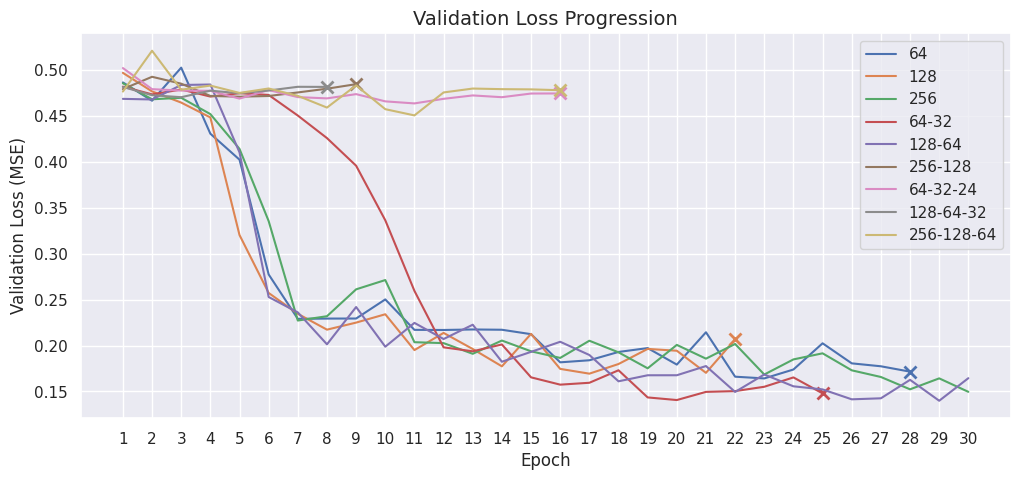

In [ ]:
plot_losses(names, histories)

**Second Round**

In [ ]:
def build_models(n_nets):
  """
  Creates a list of different experimental ANN models

  Args
  ---------
  int n_nets: the number of experimental models

  Returns
  -------
  list models: a list of compiled ANN models
  """

  models = [Sequential() for _ in range(n_nets)]

  for i, model in enumerate(models):

    model.add(Input(shape=(n_features, 1)))

    match i:
      case 0:
        model.add(LSTM(32))
      case 1:
        model.add(LSTM(64))
      case 2:
        model.add(LSTM(128))
      case 3:
        model.add(LSTM(256))
      case 4:
        model.add(LSTM(32, return_sequences=True))
        model.add(LSTM(24))
      case 5:
        model.add(LSTM(64, return_sequences=True))
        model.add(LSTM(32))
      case 6:
        model.add(LSTM(64, return_sequences=True))
        model.add(LSTM(64))
      case 7:
        model.add(LSTM(128, return_sequences=True))
        model.add(LSTM(64, return_sequences=True))

    model.add(Flatten())
    model.add(Dense(24))

    model.compile(optimizer=adam, loss='mse')

  return models

In [ ]:
names  = ['32', '64', '128', '256', '32-24', '64-32', '64-64', '128-64',]
models = build_models(len(names))
stats, histories = train_models(models, names)
stats

32	 --> Done in 22.49 sec.
64	 --> Done in 22.51 sec.
128	 --> Done in 22.26 sec.
256	 --> Done in 43.20 sec.
32-24	 --> Done in 44.34 sec.
64-32	 --> Done in 23.97 sec.
64-64	 --> Done in 44.70 sec.
128-64	 --> Done in 44.29 sec.

Succesfully trained 8 models


,name,mape,loss,best_epoch
0,32,5.225,0.1765,17
1,64,5.059,0.1704,18
2,128,5.391,0.1822,15
3,256,4.465,0.1417,23
4,32-24,5.477,0.1905,20
5,64-32,5.395,0.1885,13
6,64-64,4.952,0.1622,15
7,128-64,3.567,0.1152,24


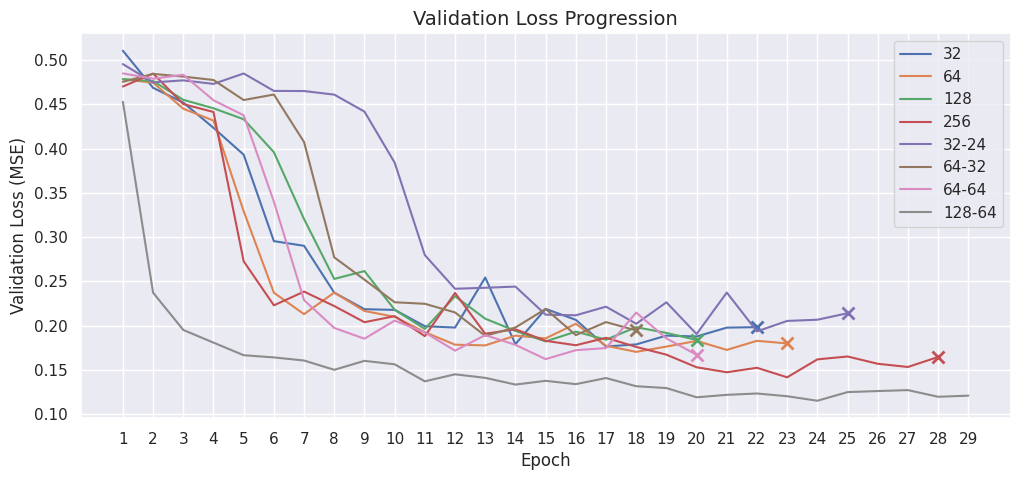

In [ ]:
plot_losses(names, histories)

### Dropout

In [ ]:
def build_models(n_nets):
  """
  Creates a list of different experimental ANN models

  Args
  ---------
  int n_nets: the number of experimental models

  Returns
  -------
  list models: a list of compiled ANN models
  """

  models = [Sequential() for _ in range(n_nets)]

  for i, model in enumerate(models):

    model.add(Input(shape=(n_features, 1)))
    model.add(LSTM(128, return_sequences=True))

    match i:
      case 0:
          model.add(LSTM(64, return_sequences=True))
      case 1:
          model.add(Dropout(0.05))
          model.add(LSTM(64, return_sequences=True))
          model.add(Dropout(0.05))
      case 2:
          model.add(Dropout(0.1))
          model.add(LSTM(64, return_sequences=True))
          model.add(Dropout(0.1))
      case 3:
          model.add(Dropout(0.15))
          model.add(LSTM(64, return_sequences=True))
          model.add(Dropout(0.15))
      case 4:
          model.add(Dropout(0.2))
          model.add(LSTM(64, return_sequences=True))
          model.add(Dropout(0.2))
      case 5:
          model.add(Dropout(0.25))
          model.add(LSTM(64, return_sequences=True))
          model.add(Dropout(0.25))
      case 6:
          model.add(Dropout(0.3))
          model.add(LSTM(64, return_sequences=True))
          model.add(Dropout(0.3))
      case 7:
          model.add(Dropout(0.35))
          model.add(LSTM(64, return_sequences=True))
          model.add(Dropout(0.35))
      case 8:
          model.add(Dropout(0.4))
          model.add(LSTM(64, return_sequences=True))
          model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(24))

    model.compile(optimizer=adam, loss='mse')

  return models

In [ ]:
names  = ['0%', '5%', '10%', '15%', '20%', '25%', '30%', '35%', '40%']
models = build_models(len(names))
stats, histories = train_models(models, names)
stats

0%	 --> Done in 44.60 sec.
5%	 --> Done in 35.24 sec.
10%	 --> Done in 44.70 sec.
15%	 --> Done in 28.80 sec.
20%	 --> Done in 44.51 sec.
25%	 --> Done in 44.73 sec.
30%	 --> Done in 36.19 sec.
35%	 --> Done in 34.95 sec.
40%	 --> Done in 44.29 sec.

Succesfully trained 9 models


,name,mape,loss,best_epoch
0,0%,3.555,0.1151,22
1,5%,3.599,0.1196,20
2,10%,3.58,0.1168,26
3,15%,3.627,0.1223,15
4,20%,3.727,0.12,23
5,25%,3.522,0.1127,27
6,30%,3.629,0.1176,25
7,35%,3.631,0.1199,19
8,40%,3.558,0.1141,22


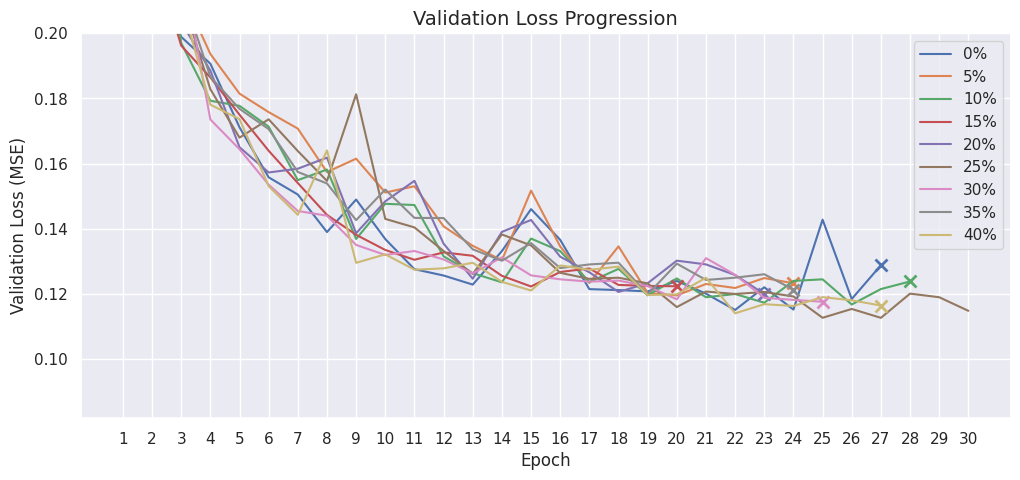

In [ ]:
plot_losses(names, histories, ylim=0.2)

### Convolutional Layers

In [ ]:
def build_models(n_nets):
  """
  Creates a list of different experimental ANN models

  Args
  ---------
  int n_nets: the number of experimental models

  Returns
  -------
  list models: a list of compiled ANN models
  """

  models = [Sequential() for _ in range(n_nets)]

  for i, model in enumerate(models):

    model.add(Input(shape=(n_features, 1)))

    match i:
      case 0:
        model.add(LSTM(128, return_sequences=True))
        model.add(Dropout(0.25))
        model.add(LSTM(64, return_sequences=True))
        model.add(Dropout(0.25))
      case 1:
        model.add(LSTM(256, return_sequences=True))
        model.add(Dropout(0.25))
        model.add(Conv1D(128, kernel_size=4))
        model.add(MaxPooling1D(pool_size=4))
        model.add(Dropout(0.25))
      case 2:
        model.add(LSTM(128, return_sequences=True))
        model.add(Dropout(0.25))
        model.add(Conv1D(64, kernel_size=4))
        model.add(MaxPooling1D(pool_size=4))
        model.add(Dropout(0.25))
      case 3:
        model.add(LSTM(64, return_sequences=True))
        model.add(Dropout(0.25))
        model.add(Conv1D(64, kernel_size=4))
        model.add(MaxPooling1D(pool_size=4))
        model.add(Dropout(0.25))
      case 4:
        model.add(Conv1D(256, kernel_size=4))
        model.add(MaxPooling1D(pool_size=4))
        model.add(Dropout(0.25))
        model.add(LSTM(128, return_sequences=True))
        model.add(Dropout(0.25))
      case 5:
        model.add(Conv1D(128, kernel_size=4))
        model.add(MaxPooling1D(pool_size=4))
        model.add(Dropout(0.25))
        model.add(LSTM(64, return_sequences=True))
        model.add(Dropout(0.25))
      case 6:
        model.add(Conv1D(64, kernel_size=4))
        model.add(MaxPooling1D(pool_size=4))
        model.add(Dropout(0.25))
        model.add(LSTM(64, return_sequences=True))
        model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(24))

    model.compile(optimizer=adam, loss='mse')

  return models

In [ ]:
names  = ['L128-L64', 'L256-C128', 'L128-C64', 'L64-C64', 'C256-L128', 'C128-L64', 'C64-L64']
models = build_models(len(names))
stats, histories = train_models(models, names)
stats

L128-L64	 --> Done in 25.78 sec.
L256-C128	 --> Done in 85.32 sec.
L128-C64	 --> Done in 42.92 sec.
L64-C64	 --> Done in 21.89 sec.
C256-L128	 --> Done in 22.53 sec.
C128-L64	 --> Done in 12.64 sec.
C64-L64	 --> Done in 9.97 sec.

Succesfully trained 7 models


,name,mape,loss,best_epoch
0,L128-L64,3.688,0.1258,11
1,L256-C128,3.749,0.1212,29
2,L128-C64,3.879,0.1219,23
3,L64-C64,3.967,0.1273,26
4,C256-L128,3.521,0.1058,22
5,C128-L64,3.371,0.1063,28
6,C64-L64,3.174,0.095,29


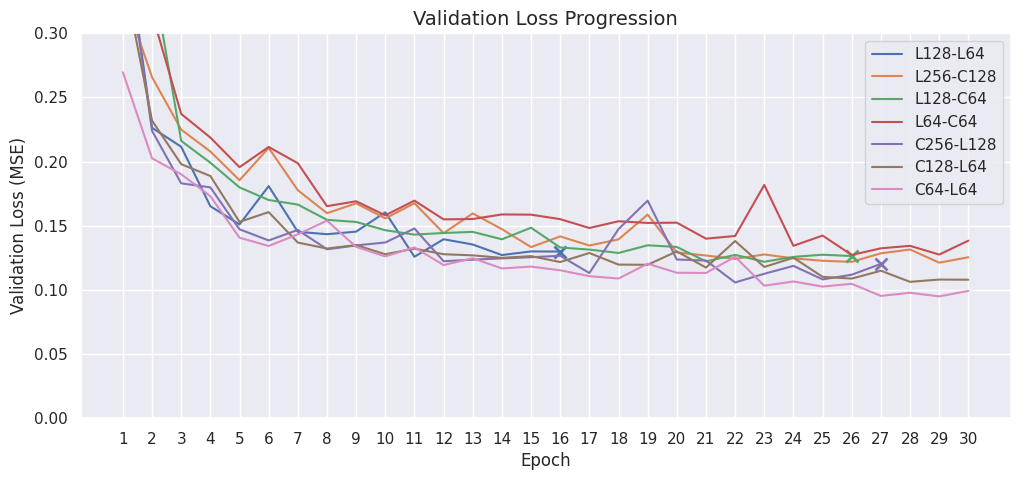

In [ ]:
plot_losses(names, histories, ylim=0.3)

### Extra Dense Layers

In [ ]:
def build_models(n_nets):
  """
  Creates a list of different experimental ANN models

  Args
  ---------
  int n_nets: the number of experimental models

  Returns
  -------
  list models: a list of compiled ANN models
  """

  models = [Sequential() for _ in range(n_nets)]

  for i, model in enumerate(models):

    model.add(Input(shape=(n_features, 1)))
    model.add(Conv1D(64, kernel_size=4))
    model.add(MaxPooling1D(pool_size=4))
    model.add(Dropout(0.25))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.25))
    model.add(Flatten())

    match i:
      case 1:
        model.add(Dense(256))
      case 2:
        model.add(Dense(1024))
      case 3:
        model.add(Dense(2048))
        model.add(Dense(1024))
      case 4:
        model.add(Dense(512))
        model.add(Dense(512))
      case 5:
        model.add(Dense(1024))
        model.add(Dense(512))
        model.add(Dense(64))
      case 6:
        model.add(Dense(1024))
        model.add(Dense(512))
        model.add(Dense(256))
        model.add(Dense(64))

    model.add(Dense(24))

    model.compile(optimizer=adam, loss='mse')

  return models

In [ ]:
names  = ['No Added Layers', '256', '1024', '2048-1024', '512-512', '1024-512-64', '1024-512-256-64']
models = build_models(len(names))
stats, histories = train_models(models, names)
stats

No Added Layers	 --> Done in 11.35 sec.
256	 --> Done in 11.04 sec.
1024	 --> Done in 22.84 sec.
2048-1024	 --> Done in 56.85 sec.
512-512	 --> Done in 22.38 sec.
1024-512-64	 --> Done in 46.98 sec.
1024-512-256-64	 --> Done in 33.87 sec.

Succesfully trained 7 models


,name,mape,loss,best_epoch
0,No Added Layers,3.192,0.0897,30
1,256,3.552,0.1141,30
2,1024,3.933,0.1289,27
3,2048-1024,4.796,0.1717,30
4,512-512,3.881,0.1296,18
5,1024-512-64,4.281,0.15,28
6,1024-512-256-64,4.793,0.1762,30


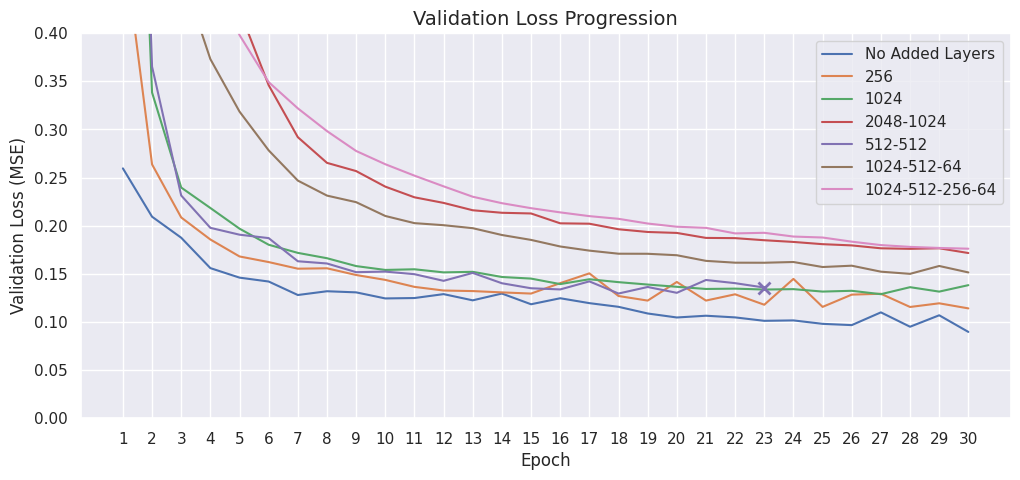

In [ ]:
plot_losses(names, histories, ylim=0.4)

### Activation Functions

In [ ]:
def build_models(n_nets):
  """
  Creates a list of different experimental ANN models

  Args
  ---------
  int n_nets: the number of experimental models

  Returns
  -------
  list models: a list of compiled ANN models
  """

  models = [Sequential() for _ in range(n_nets)]

  for i, model in enumerate(models):

    match i:
      case 0:
        activation = None
      case 1:
        activation = 'linear'
      case 2:
        activation = LeakyReLU(alpha=0.05)
      case 3:
        activation = 'relu'
      case 4:
        activation = 'sigmoid'
      case 5:
        activation = 'tanh'

    model.add(Input(shape=(n_features, 1)))
    model.add(Conv1D(64, kernel_size=4, activation=activation))
    model.add(MaxPooling1D(pool_size=4))
    model.add(Dropout(0.25))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(24))

    model.compile(optimizer=adam, loss='mse')

  return models

In [ ]:
names  = ['None', 'linear', 'leaky ReLU', 'ReLU', 'sigmoid', 'tanh']
models = build_models(len(names))
stats, histories = train_models(models, names)
stats

None	 --> Done in 9.56 sec.
linear	 --> Done in 9.82 sec.
leaky ReLU	 --> Done in 10.23 sec.
ReLU	 --> Done in 9.82 sec.
sigmoid	 --> Done in 10.99 sec.
tanh	 --> Done in 10.39 sec.

Succesfully trained 6 models


,name,mape,loss,best_epoch
0,None,3.432,0.1069,27
1,linear,3.313,0.0944,24
2,leaky ReLU,3.444,0.1145,28
3,ReLU,3.837,0.1316,19
4,sigmoid,6.643,0.285,30
5,tanh,3.043,0.08,29


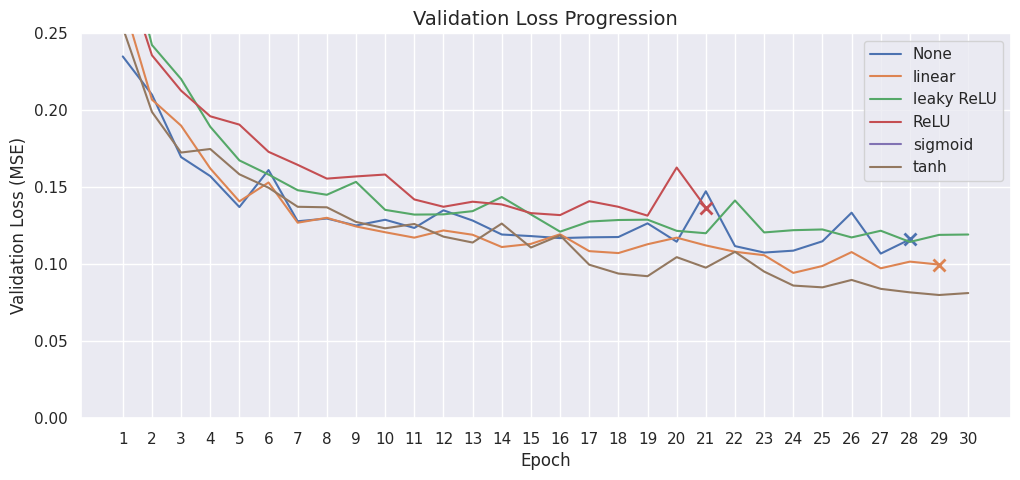

In [ ]:
plot_losses(names, histories, ylim=0.25)

### Optimizers

In [ ]:
def build_models(n_nets):
  """
  Creates a list of different experimental ANN models

  Args
  ---------
  int n_nets: the number of experimental models

  Returns
  -------
  list models: a list of compiled ANN models
  """

  models = [Sequential() for _ in range(n_nets)]

  adam = Adam()
  sgd = SGD()
  adagrad = Adagrad()
  rmsprop = RMSprop()
  nadam = Nadam()

  for i, model in enumerate(models):

    model.add(Input(shape=(n_features, 1)))
    model.add(Conv1D(64, kernel_size=4, activation='tanh'))
    model.add(MaxPooling1D(pool_size=4))
    model.add(Dropout(0.25))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(24))

    match i:
      case 0:
        optimizer = adam
      case 1:
        optimizer = sgd
      case 2:
        optimizer = adagrad
      case 3:
        optimizer = rmsprop
      case 4:
        optimizer = nadam

    model.compile(optimizer=optimizer, loss='mse')

  return models

In [ ]:
names  = ['Adam', 'SGD', 'Adagrad', 'RMSprop', 'Nadam']
models = build_models(len(names))
stats, histories = train_models(models, names)
stats

Adam	 --> Done in 12.20 sec.
SGD	 --> Done in 11.98 sec.
Adagrad	 --> Done in 11.99 sec.
RMSprop	 --> Done in 12.17 sec.
Nadam	 --> Done in 9.02 sec.

Succesfully trained 5 models


,name,mape,loss,best_epoch
0,Adam,3.286,0.0993,30
1,SGD,5.364,0.2158,30
2,Adagrad,6.911,0.3013,30
3,RMSprop,3.5,0.1138,28
4,Nadam,3.501,0.1158,17


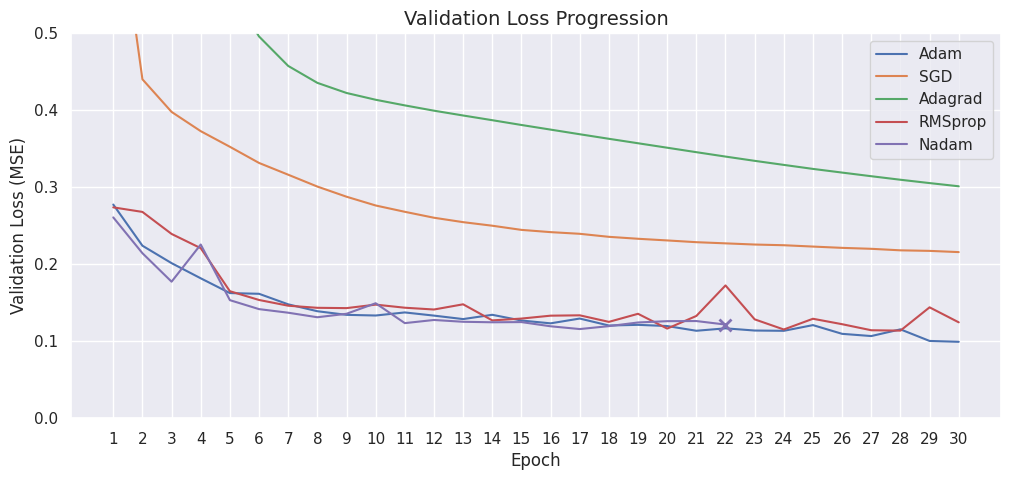

In [ ]:
plot_losses(names, histories, ylim=0.5)

### Batch Size

In [ ]:
def train_models(models, names, params):
  """
  Trains a list of ANNs and keeps track of performance metrics

  Args
  ---------
  list models: a list of compiled neural network models
  list names: str names of the models
  list params: specifies extra training parameters for each model

  Returns
  -------
  pd.DataFrame stats: the training statistics of each model
  dict histories: information about the training process such as
                  the validation loss for each epoch of training
  """

  # Specify wanted stats data for each model's training
  columns = ['name', 'mape', 'loss', 'best_epoch']
  stats = pd.DataFrame(columns=columns)
  histories = []

  # iterate through every model in the models list
  for i, model in enumerate(models):

    t_start = time()
    print(f'{names[i]}\t', end=' ')
    weights_file = models_path + f'exp{i+1}_weights.h5'

    # Use early stopping and loss checkpoint callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001)
    loss_checkpoint = ModelCheckpoint(
      filepath = weights_file,
      monitor = 'val_loss',
      save_best_only = True,
      save_weights_only = True,
      mode = 'min',
    )

    # train the model for 30 epochs
    history = model.fit(
        x_train,
        y_train,
        batch_size=params[i],
        epochs=30,
        validation_data=(x_val, y_val),
        callbacks=[early_stopping, loss_checkpoint],
        verbose=0
    )
    model.load_weights(weights_file) # retireve the weights of the best epoch

    # calculate MAPE and other statistics
    val_mape = mape_on(model, x_val, y_val)
    loss_history = history.history['val_loss']
    best_loss = round(np.min(loss_history), 4)
    best_epoch = np.argmin(loss_history) + 1

    # add statistics to the stats dataframe
    new_row = pd.Series([names[i], val_mape, best_loss, best_epoch], index=columns)
    stats.loc[len(stats)] = new_row
    # add training history to the histories list
    histories.append(history)

    print(f"--> Done in {time()-t_start:.2f} sec.")

  print(f"\nSuccesfully trained {len(models)} models")
  return stats.astype({'best_epoch':'int'}), histories

In [ ]:
def build_models(n_nets):
  """
  Creates a list of different experimental ANN models

  Args
  ---------
  int n_nets: the number of experimental models

  Returns
  -------
  list models: a list of compiled ANN models
  """

  models = [Sequential() for _ in range(n_nets)]

  for i, model in enumerate(models):

    model.add(Input(shape=(n_features, 1)))
    model.add(Conv1D(64, kernel_size=4, activation='tanh'))
    model.add(MaxPooling1D(pool_size=4))
    model.add(Dropout(0.25))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(24))
    model.compile(optimizer=Adam(), loss='mse')

  return models

In [ ]:
batch_sizes = [4, 8, 16, 32, 64, 128, 256, 512]
models = build_models(len(batch_sizes))
stats, histories = train_models(models, names=batch_sizes, params=batch_sizes)
stats

4	 --> Done in 83.73 sec.
8	 --> Done in 35.72 sec.
16	 --> Done in 22.37 sec.
32	 --> Done in 22.34 sec.
64	 --> Done in 10.59 sec.
128	 --> Done in 12.28 sec.
256	 --> Done in 12.25 sec.
512	 --> Done in 7.72 sec.

Succesfully trained 8 models


,name,mape,loss,best_epoch
0,4.0,3.056,0.0781,15
1,8.0,3.039,0.0765,25
2,16.0,2.980,0.0757,23
3,32.0,3.159,0.0870,30
4,64.0,3.382,0.1082,28
5,128.0,3.505,0.1158,26
6,256.0,3.686,0.1225,30
7,512.0,3.957,0.1348,28


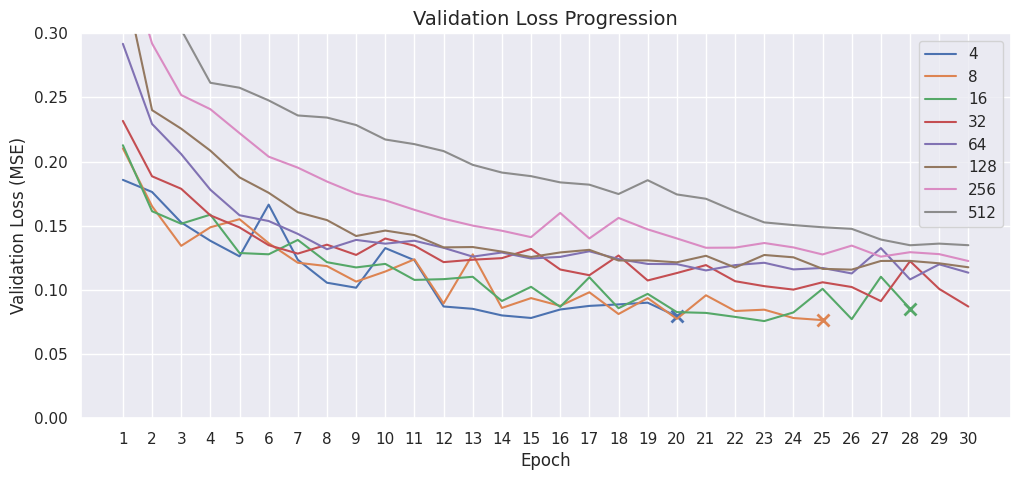

In [ ]:
plot_losses(batch_sizes, histories, ylim=0.3)

### Keras Tuner

In [ ]:
# Define early stopping and loss checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.002)
loss_checkpoint = ModelCheckpoint(
  filepath = models_path+ f'tuner_weights.h5',
  monitor = 'val_loss',
  save_best_only = True,
  save_weights_only = True,
  mode = 'min',
)

In [ ]:
def model_builder(hp):
  """
  Builds a model with architecture according to the keras tuner parameters.

  Returns
  -------
  tf.keras.Sequential model: a compiled ANN model architecture
  """
  model = Sequential()

  model.add(Input(shape=(n_features, 1)))

  filters = hp.Int('conv_filters', min_value=16, max_value=400, step=32)
  kernel_size = hp.Int('kernel_size', min_value=2, max_value=24, step=2)

  model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='tanh'))
  model.add(MaxPooling1D(pool_size=4))

  dropout_1 = hp.Float('droupout_1', min_value=0, max_value=0.4, step=0.05)
  model.add(Dropout(dropout_1))

  lstm_units = hp.Int('lstm_units', min_value=16, max_value=400, step=32)
  model.add(LSTM(units=lstm_units, return_sequences=True))

  dropout_2 = hp.Float('droupout_2', min_value=0, max_value=0.4, step=0.05)
  model.add(Dropout(dropout_2))

  model.add(Flatten())

  if hp.Boolean('extra_dense'):
      model.add(Dense(256))

  model.add(Dense(24))

  lr = hp.Float('learning_rate', min_value=0.0005, max_value=0.005, step=0.00025)

  model.compile(optimizer=Adam(learning_rate=lr), loss='mse')

  return model

In [ ]:
# Run Bayesian Optimization to find the model with the best hyperparameters
tuner = BayesianOptimization(
    model_builder,
    objective='val_loss',
    executions_per_trial=1,
    max_trials=50,
    directory=models_path,
    project_name='tuner',
    overwrite=True
)

# Train each model
tuner.search(x_train, y_train,
             validation_data=(x_val, y_val),
             epochs=30,
             callbacks=[early_stopping, loss_checkpoint]
)

# Get statistics of best model
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

Trial 50 Complete [00h 01m 24s]
val_loss: 0.1207948550581932

Best val_loss So Far: 0.0748479813337326
Total elapsed time: 00h 39m 01s


In [ ]:
# Print the hyperparameters of the best 5 models
for i, trial in enumerate(tuner.oracle.get_best_trials(num_trials=5)):
    print(f"Model {i+1}:")
    print(trial.hyperparameters.values)
    print(f"Validation loss: {trial.score:.4f}")
    print()

Model 1:
{'conv_filters': 208, 'kernel_size': 4, 'droupout_1': 0.30000000000000004, 'lstm_units': 208, 'droupout_2': 0.1, 'extra_dense': False, 'learning_rate': 0.001}
Validation loss: 0.0748

Model 2:
{'conv_filters': 336, 'kernel_size': 4, 'droupout_1': 0.2, 'lstm_units': 48, 'droupout_2': 0.30000000000000004, 'extra_dense': False, 'learning_rate': 0.0022500000000000003}
Validation loss: 0.0757

Model 3:
{'conv_filters': 112, 'kernel_size': 4, 'droupout_1': 0.2, 'lstm_units': 304, 'droupout_2': 0.1, 'extra_dense': True, 'learning_rate': 0.00175}
Validation loss: 0.0771

Model 4:
{'conv_filters': 112, 'kernel_size': 4, 'droupout_1': 0.30000000000000004, 'lstm_units': 144, 'droupout_2': 0.25, 'extra_dense': False, 'learning_rate': 0.002}
Validation loss: 0.0785

Model 5:
{'conv_filters': 80, 'kernel_size': 4, 'droupout_1': 0.25, 'lstm_units': 80, 'droupout_2': 0.25, 'extra_dense': True, 'learning_rate': 0.0045000000000000005}
Validation loss: 0.0821



In [ ]:
def train_models(models, names):
  """
  Trains a list of ANNs and keeps track of performance metrics

  Args
  ---------
  list models: a list of compiled neural network models
  list names: str names of the models

  Returns
  -------
  pd.DataFrame stats: the training statistics of each model
  dict histories: information about the training process such as
                  the validation loss for each epoch of training
  """

  # Specify wanted stats data for each model's training
  columns = ['name', 'mape', 'loss', 'best_epoch']
  stats = pd.DataFrame(columns=columns)
  histories = []

  # iterate through every model in the models list
  for i, model in enumerate(models):

    t_start = time()
    print(f'{names[i]}\t', end=' ')

    weights_file = models_path + f'exp{i+1}_weights.h5'

    # Use early stopping and loss checkpoint callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001)
    loss_checkpoint = ModelCheckpoint(
      filepath = weights_file,
      monitor = 'val_loss',
      save_best_only = True,
      save_weights_only = True,
      mode = 'min',
    )

    # train the model for 30 epochs
    history = model.fit(
        x_train,
        y_train,
        batch_size=16,
        epochs=30,
        validation_data=(x_val, y_val),
        callbacks=[early_stopping, loss_checkpoint],
        verbose=0
    )

    model.load_weights(weights_file) # retireve the weights of the best epoch

    # calculate MAPE and other statistics
    val_mape = mape_on(model, x_val, y_val)
    loss_history = history.history['val_loss']
    best_loss = round(np.min(loss_history), 4)
    best_epoch = np.argmin(loss_history) + 1

    # add statistics to the stats dataframe
    new_row = pd.Series([names[i], val_mape, best_loss, best_epoch], index=columns)
    stats.loc[len(stats)] = new_row
    # add training history to the histories list
    histories.append(history)

    print(f"--> Done in {time()-t_start:.2f} sec.")

  print(f"\nSuccesfully trained {len(models)} models")
  return stats.astype({'best_epoch':'int'}), histories

In [ ]:
# Create the original CNN-LSTM model that was found throught the emperical experiments
original_model = tf.keras.Sequential([
  Input(shape=(n_features, 1)),
  Conv1D(64, kernel_size=4, activation='tanh'),
  MaxPooling1D(pool_size=4),
  Dropout(0.25),
  LSTM(64, return_sequences=True),
  Dropout(0.25),
  Flatten(),
  Dense(24)
])

original_model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))

In [ ]:
# Create a list of the top 5 models plus the original model and test them against each other
top5_models = tuner.get_best_models(5)
top_models = [original_model] + top5_models

names = ['Original'] + [f'Model {i+1}' for i in range(5)]

stats, histories = train_models(top_models, names)
stats

Original	 --> Done in 22.68 sec.
Model 1	 --> Done in 41.71 sec.
Model 2	 --> Done in 41.66 sec.
Model 3	 --> Done in 82.85 sec.
Model 4	 --> Done in 23.30 sec.
Model 5	 --> Done in 41.90 sec.

Succesfully trained 6 models


,name,mape,loss,best_epoch
0,Original,3.016,0.0771,17
1,Model 1,3.033,0.0763,30
2,Model 2,2.789,0.0649,20
3,Model 3,3.092,0.0775,24
4,Model 4,3.167,0.0794,20
5,Model 5,3.222,0.0785,28
